In [4]:
 # All requirements: Dijkstar, pandas, geopandas, shapely, matplotlib, folium 

import pandas as pd
import geopandas as gpd

In [53]:
# Import Geopackages
VeloWege = gpd.read_file(r'data/Velo_wege.gpkg', crs = "epsg:2056")
Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg', crs = "epsg:2056")

In [3]:
# Import CSV
VerkehrsZaehlung = pd.read_csv(r'data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv')

# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(
    VerkehrsZaehlung, geometry=gpd.points_from_xy(VerkehrsZaehlung.OST, VerkehrsZaehlung.NORD), crs = "epsg:2056")

## EDA
1: First, we will conduct an EDA on all three data-sets to get a feeling for the data


<AxesSubplot:>

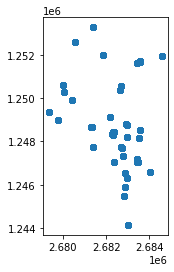

In [4]:
Zaehlungen.plot()

In [5]:
Zaehlungen.head(3)

,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD,geometry
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,20.0,0.0,2682973,1246329,POINT (2682973.000 1246329.000)
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,NaN,NaN,2682873,1245891,POINT (2682873.000 1245891.000)
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,4.0,1.0,2683557,1251702,POINT (2683557.000 1251702.000)


<AxesSubplot:>

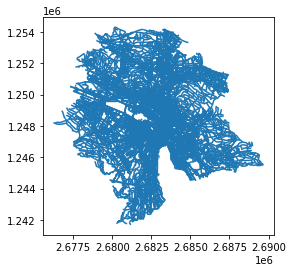

In [6]:
VeloWege.plot()

In [7]:
VeloWege.head(3)

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6..."


<AxesSubplot:>

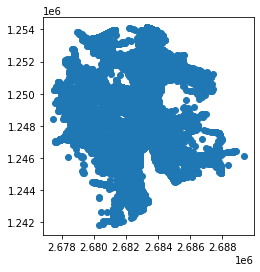

In [8]:
Unfaelle.plot()

In [75]:
# Filter to only contain Accidents involving Bikes
VeloUnfaelle = Unfaelle.loc[Unfaelle['AccidentInvolvingBicycle']==True]

In [10]:
VeloUnfaelle.head(3)

,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,geometry
1,9FD6441F802C20A6E0430A865E3320A6,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,1.0,01h-02h,POINT (2682382.000 1246980.000)
9,9FDA0D984DA49018E0430A865E339018,at8,Fussgängerunfall,accident impliquant des piétons,Incidente con pedoni,Accident involving pedestrian(s),as2,Unfall mit Schwerverletzten,accident avec blessés graves,Incidente con feriti gravi,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,15.0,15h-16h,POINT (2683238.000 1246773.000)
19,9FC2F14A65F30050E0430A865E330050,at3,Abbiegeunfall,accident en quittant une route,Incidente nello svoltare,Accident when turning left or right,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw401,Montag,lundi,Lunedí,Monday,8.0,08h-09h,POINT (2681179.000 1247560.000)


#### EDA Conclusions
- we have all data in LV95 (epsg:2056)
    - this is good for analysis. if we face problems with visualizing in the end, we can use the following pyproj transformer to project it into WGS84 webmercator
- the Zaehlungen set is quite large (beacause of it's huge time dimension), we need to work smart with it and not do loops on it
- the Unfaelle have to be filtered! To only include the bicycle ones.
- we know which LineStrings are oneway streets.... but all bicyclists are criminals, so that dosen't matter ;)

In [11]:
# Convert Coordinate Columns from LV95 to WGS84
# from pyproj import Transformer
#
# CHtoWGS = Transformer.from_crs("epsg:2056", "epsg:4326")
# df['Longitude'], df['Latitude'] = CHtoWGS.transform(df['OST'], df['NORD'])
#
# --> Everything is in epsg:2056, we might only need to transform into WebMercator for visualization

## Segmentation
2: We segment the bicycle path network into nodes and edges
- **Not needed! The path network is already segmented :)**
    - It contains "edges only" - it is split at every node
- Checked the gpkg in QGIS, easy to see

## Attribute Accidents to Edges (Line Segments). 
3: Accidents get also attributed by severity of the accident (categories already set by raw data)<br>
- Goal: gdf with Edges and geographically matched incident attributes
    - We need to think about how this should look like. 
        - Do we need to keep the single accidents? 
        - Should we summarize only geographically and get rid of time? <br>
--> add id1 from VeloWege to accidents

#### There is a Funciton in Shapley for the reverse (closest Point to Line)
But that dosen't help us, as we would get multiple matches

In [12]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point

p = Point(11,8)  # geometry1
line = LineString([(0, 0), (5, 7), (12, 6)])  # geometry2
p2 = nearest_points(line, p)[0]
print(p2)  # POINT (5 7)

POINT (10.74 6.18)


So we kept on looking, finding a method to search for closest lines!

#### This works... 
https://gis.stackexchange.com/questions/81613
... but is way to slow

In [13]:
from shapely.geometry import Point, LineString, mapping, shape
from shapely.ops import cascaded_union
from shapely import affinity


def ClosestLine(point, line_gdf):
    
    sweep_res = 20  # sweep resolution (degrees)
    focal_pt = point  # radial sweep centre point
    sweep_radius = 100.0  # sweep radius

    # create the radial sweep lines
    line = LineString([(focal_pt.x,focal_pt.y), \
                    (focal_pt.x, focal_pt.y + sweep_radius)])

    sweep_lines = [affinity.rotate(line, i, (focal_pt.x, focal_pt.y)) \
                for i in range(0, 360, sweep_res)]

    radial_sweep = cascaded_union(sweep_lines)

    # load the input lines and combine them into one geometry
    # input_lines = line_gdf.geometry #fiona.open("input_lines.shp")
    input_shapes = line_gdf.geometry  #[shape(f['geometry']) for f in input_lines]
    all_input_lines = cascaded_union(input_shapes)

    perimeter = []
    # traverse each radial sweep line and check for intersection with input lines
    for radial_line in radial_sweep:
        inter = radial_line.intersection(all_input_lines)

        if inter.type == "MultiPoint":
        # radial line intersects at multiple points
            inter_dict = {}
            for inter_pt in inter:
                inter_dict[focal_pt.distance(inter_pt)] = inter_pt
        # save the nearest intersected point to the sweep centre point
            perimeter.append(inter_dict[min(inter_dict.keys())])

        if inter.type == "Point":
        # radial line intersects at one point only
            perimeter.append(inter)

        if inter.type == "GeometryCollection":
        # radial line doesn't intersect, so skip
            pass

    # combine the nearest perimeter points into one geometry
    solution = LineString(cascaded_union(perimeter))

    return solution

It is computationally also a very unelegant solution (considering the loops), therfore it takes super long too. Here an approximation in hours:

In [14]:
(len(VeloUnfaelle) / 5 * 70)/60/60
# it took 70s for 5 segments to process

23.298333333333336

### Let's try something else...

Goal: give every Accident the ID of the closest Road segment.
Idea: Point in Polygon; Voronoi for LineSegments

While working on this idea, we needed to split the lines into vertices to create the Voronoi cells, since there seems to be no good algorithm to create Voronoi cells from lines. The idea was to then merge all Voronoi cells (created with the vertices) which intersect with the orginal line to build a cell for the whole line segment. <br>
We used QGIS to split the lines in vertices, as it has a very efficent function for that: <br>
We show the ```QGIS Python code``` for reproducabillity. 

With QGIS:
- Load Lines gpkg
- Vector > Geometry Tools > Extract Vertices
    - ```processing.run("native:extractvertices", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/Velo_wege.gpkg|layername=taz_mm_tbl_routennetz|geometrytype=LineString','OUTPUT':'TEMPORARY_OUTPUT'}) ```
- Resulting in a temporary new Point Layer
- Vector > Geometry Tools > Voronoi Polygons
    - ```processing.run("qgis:voronoipolygons", {'INPUT':'memory://Point?crs=EPSG:2056&field=id:long(0,0)&field=id1:long(0,0)&field=velo:integer(0,0)&field=velostreifen:string(5,0)&field=veloweg:integer(0,0)&field=einbahn:string(5,0)&field=fuss:integer(0,0)&field=name:string(150,0)&field=map_velo:integer(0,0)&field=map_fuss:integer(0,0)&field=se_anno_cad_data:binary(0,0)&field=objectid:double(0,0)&field=vertex_index:integer(10,0)&field=vertex_part:integer(10,0)&field=vertex_part_index:integer(10,0)&field=distance:double(20,14)&field=angle:double(20,14)&uid={19c7245c-2773-410f-bd82-3fbf1fd3116f}','BUFFER':0,'OUTPUT':'TEMPORARY_OUTPUT'})```

But we realized, that the resulting Voronoi cells had some flaws. The algorithm drew some random huge cells over other cells. We could of course manully delete to big cells, but we wanted a cleaner approach. We realized that with QGIS it is posible to find the nearest point of another point. Which we can now do with the vertices of our Line Segments:

With QGIS again:
- We still have the temporary new Point Layer containing the Vertices of the Bike Network Line Segments.
- Vector > Analysis Tools > Distance Matrix...
    - ```processing.run("qgis:distancematrix", {'INPUT':'/home/linusrg/Code/Velo-Zueri/Velo-Zueri-Unfaelle/data/VeloUnfaelle.gpkg|layername=VeloUnfaelle','INPUT_FIELD':'AccidentUID','TARGET':'memory://memory?geometry=Point&crs=EPSG:2056&field=id:int8(0,0)&field=id1:int8(0,0)&field=velo:integer(0,0)&field=velostreifen:string(5,0)&field=veloweg:integer(0,0)&field=einbahn:string(5,0)&field=fuss:integer(0,0)&field=name:string(150,0)&field=map_velo:integer(0,0)&field=map_fuss:integer(0,0)&field=se_anno_cad_data:binary(0,0)&field=objectid:double(0,0)&field=vertex_index:integer(10,0)&field=vertex_part:integer(10,0)&field=vertex_part_index:integer(10,0)&field=distance:double(20,14)&field=angle:double(20,14)&uid={9918bfc2-204d-4ba5-8029-2cb852b1148f}','TARGET_FIELD':'id1','MATRIX_TYPE':0,'NEAREST_POINTS':1,'OUTPUT':'TEMPORARY_OUTPUT'})```
- We then exported the matrix as csv and import it here again:   

In [72]:
DistMatrix = pd.read_csv("data/DistanceMatrix.csv")
#InputID: VeloUnfaelle['AccidentUID']
#TargetID: VeloWege['id1']

DistMatrix.rename(columns = {'InputID':'AccidentUID', 'TargetID':'id1'}, inplace = True)

In [73]:
DistMatrix.head(3)

,AccidentUID,id1,Distance
0,9FD6441F802C20A6E0430A865E3320A6,1006,8.229085
1,9FDA0D984DA49018E0430A865E339018,3101,4.105777
2,9FC2F14A65F30050E0430A865E330050,6904,1.398630


#### Adding the LineSegment ID to the Accidents

In [76]:
VeloUnfaelle = pd.merge(VeloUnfaelle, DistMatrix, on="AccidentUID", how="inner")

#### Giving the Edges (our LineSegments) a weight


In [77]:
timeAx = sorted(VeloUnfaelle['AccidentHour'].unique())
timeAx = list(map(int, timeAx))
print(timeAx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [78]:
wayAx = sorted(DistMatrix['id1'].unique())
wayAx = list(map(int, wayAx))

In [79]:
Weights = pd.DataFrame(0,
                    columns = timeAx,
                    index = wayAx)

In [80]:
Weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### The Weight - This is a hard ethical Question
We have four categories: as1 - somebody died, as2 - someone was heavily injured, as3 - someone was lightly injured, as4 - material damage only. Now we have to weigh those categories numerically. 

In [81]:
severityDict = {'as1': 100,'as2': 50, 'as3': 20, 'as4':5 }

In [82]:
VeloUnfaelle['SeverityWeight'] = VeloUnfaelle['AccidentSeverityCategory'].map(severityDict)

In [83]:
for way in wayAx:    
    for time in timeAx:
        Weights.at[way, time] = VeloUnfaelle.loc[(VeloUnfaelle['AccidentHour'] == time) & (VeloUnfaelle['id1'] == way), 'SeverityWeight'].sum()
# Not super elegant, but it only runs for ca 1min.

In [69]:
Weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,0,0,0,0,20,20,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,20,50,...,0,0,0,0,20,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,20,...,0,0,0,0,0,0,0,0,0,0
21,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,20,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47192,0,0,0,0,0,0,0,0,20,0,...,0,0,0,0,0,0,0,0,0,0
47512,0,0,0,0,0,0,0,0,0,0,...,0,20,0,0,0,0,0,0,0,0
47513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,20,0,0,0,0,0,0


## Normalization
4: Then, accidents normalized by the closest (determined via Voronoi tessellation) counting station value. 
The resulting graph of safety-weighted edges has an x, y and t (Lat, Long and Daytime) dimension. 

##### Check "maurus-notebook.ipynb" for the detailed steps!
I just directly import the there produced layer.

<AxesSubplot:>

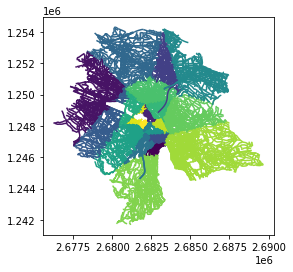

In [59]:
VeloWege_Weights = gpd.read_file(r'data/RadWege_Weight.gpkg')
VeloWege_Weights.plot(column='Weight', cmap='viridis')

These values approximate the total bicycle traffic in the voronoi cells encompassing the counting station where the value was created. We then attribute every LineSegement of the Bicycle Network with the spatially closest counting station. The values are calculated by dividing the total number of bicyclists in the City of Zurich ....

In [60]:
VeloWege_Weights.Weight.unique()

array(['0.067837', '0.00061', '0.026143', '0.017653', '0.073929',
       '0.042095', '0.035435', '0.027373', '0.169791', '0.01289',
       '0.088292', '0.056389', '0.012607', '0.116325', '0.047695',
       '0.046516', '0.025107', '0.054176', '0.015626', '0.025979',
       '0.032641', '0.004892\n', None], dtype=object)

In [61]:
type(VeloWege_Weights.Weight[:1].item())

str

In [62]:
corrDict = {'0.004892\n': '0.004892', None : '0.01', '0.067837': '0.067837', '0.00061': '0.00061', '0.026143': '0.026143', '0.017653': '0.017653', '0.073929': '0.073929', '0.042095': '0.042095', '0.035435': '0.035435', '0.027373': '0.027373', '0.169791': '0.169791', '0.01289': '0.01289', '0.088292':'0.088292', '0.056389':'0.056389',  '0.012607':'0.012607', '0.116325': '0.116325', '0.047695':'0.047695', '0.046516': '0.046516', '0.025107': '0.025107', '0.054176': '0.054176', '0.015626': '0.015626', '0.025979': '0.025979', '0.032641': '0.032641'}
VeloWege_Weights.Weight = VeloWege_Weights.Weight.map(corrDict)
VeloWege_Weights.Weight.unique()

array(['0.067837', '0.00061', '0.026143', '0.017653', '0.073929',
       '0.042095', '0.035435', '0.027373', '0.169791', '0.01289',
       '0.088292', '0.056389', '0.012607', '0.116325', '0.047695',
       '0.046516', '0.025107', '0.054176', '0.015626', '0.025979',
       '0.032641', '0.004892', '0.01'], dtype=object)

In [63]:
VeloWege_Weights.Weight = VeloWege_Weights.Weight.astype(float)*100
VeloWege = VeloWege_Weights

In [64]:
VeloWege.Weight.unique()

array([ 6.7837,  0.061 ,  2.6143,  1.7653,  7.3929,  4.2095,  3.5435,
        2.7373, 16.9791,  1.289 ,  8.8292,  5.6389,  1.2607, 11.6325,
        4.7695,  4.6516,  2.5107,  5.4176,  1.5626,  2.5979,  3.2641,
        0.4892,  1.    ])

In [ ]:
# We drop duplicates, that occured because of unclean street to voronoi cell attribution (overlaying voronoi cells)
VeloWege = VeloWege.drop_duplicates(subset=['id1'])

We will multiply this in, when we populate our graph.

## Model
5: We will then use this graph to train a model (Maybe SVM, GCN or we will see what the lecture brings us).
The model should then be capable to predict the safety of any rout at any time in Zurich <br>
--> Well, we do not need a model to do that, we need an algorithm :)<br>
Source = https://pythonwife.com/dijkstras-algorithm-in-python/ <br>
<br>
We built the Algorithm according to the mentioned source to understand it, but we found a Library which works better. <br>
So in the end we used the library


In [25]:
#Initializing the Graph Class
from collections import defaultdict


class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(list)
        self.distances = {}
    
    def addNode(self,value):
        self.nodes.add(value)
    
    def addEdge(self, fromNode, toNode, distance):
        self.edges[fromNode].append(toNode)
        self.distances[(fromNode, toNode)] = distance

#Implementing Dijkstra's Algorithm
def dijkstra(graph, initial):
    visited = {initial : 0}
    path = defaultdict(list)

    nodes = set(graph.nodes)

    while nodes:
        minNode = None
        for node in nodes:
            if node in visited:
                if minNode is None:
                    minNode = node
                elif visited[node] < visited[minNode]:
                    minNode = node
        if minNode is None:
            break

        nodes.remove(minNode)
        currentWeight = visited[minNode]

        for edge in graph.edges[minNode]:
            weight = currentWeight + graph.distances[(minNode, edge)]
            if edge not in visited or weight < visited[edge]:
                visited[edge] = weight
                path[edge].append(minNode)
    
    return visited, path

In [26]:
# Example Graph
customGraph = Graph()
customGraph.addNode("A")
customGraph.addNode("B")
customGraph.addNode("C")
customGraph.addNode("D")
customGraph.addNode("E")
customGraph.addNode("F")
customGraph.addNode("G")
customGraph.addEdge("A", "B", 2)
customGraph.addEdge("A", "C", 5)
customGraph.addEdge("B", "C", 6)
customGraph.addEdge("B", "D", 1)
customGraph.addEdge("B", "E", 3)
customGraph.addEdge("C", "F", 8)
customGraph.addEdge("D", "E", 4)
customGraph.addEdge("E", "G", 9)
customGraph.addEdge("F", "G", 7)

print(dijkstra(customGraph, "B"))

({'B': 0, 'C': 6, 'D': 1, 'E': 3, 'G': 12, 'F': 14}, defaultdict(<class 'list'>, {'C': ['B'], 'D': ['B'], 'E': ['B'], 'G': ['E'], 'F': ['C']}))


### Building the Graph

So we need nodes (the start and end points). We need to create them from our VeloWege gdf:

In [65]:
# Create a new column with start an endpoint as a MultiPoint object
VeloWege['boundary'] = VeloWege.geometry.boundary

In [71]:
# Function to split the MultiPoint Object into two points
# First try, didn't work as planed 
def getVertices(row):
    line = VeloWege['boundary'][row]
    first, last = line.boundary
    return(first, last)

To make linestrings connect, we will get rid of the decimals and the last cartesian cordiante digit (so we are still have an accuracy of ten meters) --> we need this to connect street segments

In [66]:
# So we used string slicing :)

def shortLV95(coords):
    east = coords.split(" ")[0][:5]
    north = coords.split(" ")[1][:5]
    return f"{east}-{north}"

def getVerticesSlicer(wkt, position = "First"):
    string = str(wkt)
    if len(string) < 40:
        return "nein", "nein"
    elif position == "Last":
        list = string.split(", ")
        last = list[1].split(")")[0]
        last = shortLV95(last)
        return str(last)
    else:
        list = string.split(", ")
        first = list[0].split("(")[1]
        first = shortLV95(first)
        return str(first)

In [114]:
# create empty columns for the nodes (first and last)
VeloWege['last'] = ""
VeloWege['first'] = ""

# apply function
VeloWege['last'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt, position = "Last"), axis = 1)
VeloWege['first'] = VeloWege.apply(lambda row : getVerticesSlicer(row['boundary'].wkt), axis = 1)

# Our unique nodes
nodes = pd.concat([VeloWege['last'], VeloWege['first']], axis = 0).unique()

/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/home/linusrg/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

### Initalize Graph Class
Now we need to find all combinations and theire weights...

In [84]:
time = 16 # Here we choose the hour of the day to build the Graph
# Initalze Graph
ZueriVelo = Graph()

#Add Vertices
for vertex in nodes:
    if vertex == ('nein', 'nein'):
        continue
    else:
        ZueriVelo.addNode(vertex)


#Add Edges
for idx, row in Weights.iterrows():
    weight = Weights.loc[idx, time]
    first = VeloWege.loc[VeloWege['id1'] == idx, 'first'].item()
    last = VeloWege.loc[VeloWege['id1'] == idx, 'last'].item()
    customGraph.addEdge(str(first), str(last), int(weight))
    customGraph.addEdge(str(last), str(first), int(weight))

print(dijkstra(ZueriVelo, '2684657-1246301'))

AttributeError: 'Graph' object has no attribute 'addNode'

As mentioned before, and as we can see here, our selfimplemented algorithm does not work realibly. So we used a Library:

### Dijkstar with Library

In [111]:
time = 16 # Choose hour of the day to build the Graph here

# pip install Dijkstar
from dijkstar import Graph, find_path

GrafVoZueri = Graph()
#Add Edges
for idx, row in Weights.iterrows():
    weight = Weights.loc[idx, time]
    first = VeloWege.loc[VeloWege['id1'] == idx, 'first'].item()
    last = VeloWege.loc[VeloWege['id1'] == idx, 'last'].item()
    routeweight = VeloWege.loc[VeloWege['id1'] == idx, 'Weight'].item()
    GrafVoZueri.add_edge(str(first), str(last), (int(weight)*routeweight, idx))
    GrafVoZueri.add_edge(str(last), str(first), (int(weight)*routeweight, idx))

def cost_func(u, v, edge, prev_edge):
    length, name = edge
    if prev_edge:
        prev_name = prev_edge[1]
    else:
        prev_name = None
    cost = length
    if name != prev_name:
         cost += 1 # Here we add our Basis Risk
    return cost

## Put the Algorithm to Work
Insert Start and Destination here

In [112]:
start = '26847-12462'
dest = '26818-12496'


route = find_path(GrafVoZueri, start, dest, cost_func=cost_func)
print(route)
# Create a GeoDataFrame with the LineSegment Geometries
geo_list = []
for edge in route.edges:
    geom = VeloWege.loc[VeloWege['id1'] == edge[1], 'geometry'][:1].item()
    geo_list.append(geom)


route = gpd.GeoDataFrame(zip(geo_list, route.costs), columns =['geometry', 'weight'], crs="epsg:2056")

PathInfo(nodes=['26847-12462', '26846-12463', '26845-12463', '26846-12464', '26845-12465', '26844-12467', '26843-12469', '26844-12469', '26844-12470', '26843-12470', '26842-12471', '26841-12471', '26840-12471', '26839-12472', '26838-12472', '26837-12473', '26837-12474', '26837-12475', '26836-12476', '26835-12479', '26835-12481', '26834-12481', '26834-12480', '26833-12481', '26832-12480', '26832-12481', '26830-12481', '26829-12482', '26830-12482', '26830-12483', '26830-12484', '26829-12485', '26827-12487', '26825-12489', '26823-12491', '26821-12492', '26820-12494', '26818-12495', '26819-12495', '26819-12496', '26818-12496'], edges=[(0.0, 23212), (0.0, 15004), (0.0, 35427), (0.0, 26627), (0.0, 29313), (0.0, 8512), (0.0, 16087), (0.0, 29440), (0.0, 31357), (0.0, 38918), (0.0, 37949), (0.0, 24894), (0.0, 29628), (0.0, 14144), (0.0, 39018), (0.0, 28208), (0.0, 19134), (0.0, 28842), (0.0, 7105), (0.0, 22498), (0.0, 36093), (0.0, 15445), (0.0, 5197), (0.0, 23344), (0.0, 24054), (0.0, 16148), 

## Visualization
Now we need to reproject for the Folium Visualization

In [113]:
# Convert route gdf from LV95 to WGS84
georoute = route.to_crs(crs='EPSG:4326')

import folium
import matplotlib.pyplot as plt

m = folium.Map(location=[47.38397, 8.53080], zoom_start=14, tiles='CartoDB positron')

for _, r in georoute.iterrows():
    r['weight'] # for color
    sim_geo = gpd.GeoSeries(r['geometry']) #.simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)

    geo_j.add_to(m)
m

BONUS:

If time allows it, we will also introduce the following features:
Weather data (to introduce an additional dimension, like dry, wet & frozen)
Topography (to introduce an additional weighting criteria: steepness of the segments) 
Connect our model to an actual routing engine (which uses travel time for costing of the edges)

# Function

In [115]:
def SafetyFirst(start, destination, time):
    GrafVoZueri = Graph()
    #Add Edges
    for idx, row in Weights.iterrows():
        weight = Weights.loc[idx, time]
        first = VeloWege.loc[VeloWege['id1'] == idx, 'first'].item()
        last = VeloWege.loc[VeloWege['id1'] == idx, 'last'].item()
        routeweight = VeloWege.loc[VeloWege['id1'] == idx, 'Weight'].item()
        GrafVoZueri.add_edge(str(first), str(last), (int(weight)*routeweight, idx))
        GrafVoZueri.add_edge(str(last), str(first), (int(weight)*routeweight, idx))

    route = find_path(GrafVoZueri, start, destination, cost_func=cost_func)
    print(route)

    geo_list = []
    for edge in route.edges:
        geom = VeloWege.loc[VeloWege['id1'] == edge[1], 'geometry'][:1].item()
        geo_list.append(geom)

    route = gpd.GeoDataFrame(zip(geo_list, route.costs), columns =['geometry', 'weight'], crs="epsg:2056")

    # Convert route gdf from LV95 to WGS84
    georoute = route.to_crs(crs='EPSG:4326')

    import folium
    import matplotlib.pyplot as plt

    m = folium.Map(location=[47.38397, 8.53080], zoom_start=14, tiles='CartoDB positron')

    for _, r in georoute.iterrows():
        r['weight'] # for color
        sim_geo = gpd.GeoSeries(r['geometry']) #.simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j)

        geo_j.add_to(m)
    return m

In [134]:
import random
nodes[random.randint(1, len(nodes))]

'26824-12462'

In [175]:
#start = '26847-12462'
#destination = '26818-12496'

#start = '26828-12457'
#destination = '26818-12496'

#start = '26837-12510'
#destination = '26818-12496'

#start = '26826-12501'
#destination = '26818-12496'

#start = '26850-12513'
#destination = '26818-12496'

import random
start = nodes[random.randint(1, len(nodes))]
destination = nodes[random.randint(1, len(nodes))]

time = 12

SafetyFirst(start, destination, time)

PathInfo(nodes=['26832-12471', '26831-12471', '26831-12472', '26830-12472', '26829-12473', '26828-12474', '26828-12475', '26828-12476', '26828-12478', '26828-12480', '26827-12480', '26826-12480', '26825-12479', '26824-12480', '26823-12481', '26822-12482', '26823-12484', '26823-12485', '26822-12486', '26820-12487', '26821-12488', '26820-12489', '26820-12490', '26818-12490', '26816-12491', '26817-12493', '26818-12494', '26819-12495', '26819-12496', '26818-12496'], edges=[(0, 35811), (0, 31658), (0, 27616), (0, 16632), (0, 33177), (0, 25931), (0, 23441), (0, 36305), (0, 38262), (0, 38054), (0, 38116), (0, 23385), (0, 34932), (0, 36051), (0, 30361), (0, 29407), (0, 35901), (0, 33056), (0, 3880), (0, 11885), (0, 32614), (0, 9962), (0, 3341), (0, 9253), (0, 27932), (0, 24196), (0, 27118), (0, 39233), (5, 10084)], costs=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6], total_cost=34)
